# Statistical Methods in Image Processing EE-048954
## Homework 3: Contrastive Divergence and Noise Contrastive Estimation
### Due Date: <span style="color:red">June 16, 2022</span>

###  Submission Guidelines

* Submission only in **pairs** on the course website (Moodle).
* Working environment:
    * We encourage you to work in `Jupyter Notebook` online using <a href="https://colab.research.google.com/">Google Colab</a> as it does not require any installation.
* You should submit two **separated** files:
    * A `.ipynb` file, with the name: `ee048954_hw3_id1_id2.ipynb` which contains your code implementations.
    * A `.pdf` file, with the name: `ee048954_hw3_id1_id2.pdf` which is your report containing plots, answers, and discussions.
    * **No handwritten submissions** and no other file-types (`.docx`, `.html`, ...) will be accepted.

### Mounting your drive for saving/loading stuff

In [175]:
#from google.colab import drive
#drive.mount('/content/drive')

### Importing relevant libraries

In [2]:
## Standard libraries
import os
import math
import time
import numpy as np
import random
import copy

## Scipy optimization routines
from scipy.optimize import minimize

## Progress bar
import tqdm

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
plt.style.use('ggplot')

## Part I: Contrastive Divergence (50 points)

Consider the following Gaussian Mixture Model (GMM) distribution

$$ p(x;\{\mu_i\}) = \sum_{i=1}^{N}\frac{1}{N}\,\frac{1}{{{2\pi}}} \exp\left\{-\frac{1}{2}||x-\mu_i||^2\right\} ,$$	
where $x,\mu_i \in \mathbb{R}^2$. We will use $N = 4$, $\sigma = 1$, and $\{\mu_i\} = \{(0,0)^T , (0,3)^T , (3,0)^T , (3,3)^T\}$.

#### Sampling from GMM

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 1</span>**. Direct sampling: Use your function from HW1 that accepts $\{\mu_i\}$, and returns a sample $x$ from $p(x;\{\mu_i\})$. Draw $J=1000$ samples $\{x\}$ from the distribution $p(x;\{\mu_i\})$ using this function. These will be our **real samples**.



In [25]:
def plot_scatter(samples, title, group=None):
    if group is not None:
        plt.scatter(samples[:, 0], samples[:, 1], c=group)
    else:
        plt.scatter(samples[:, 0], samples[:, 1])
    plt.title(title)
    plt.show()    

In [26]:
def sub_plot_scatter(samples_list, titles_list, width, figsize=(15,5)):
    N = len(samples_list)
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    rows = int(N/width)
    
    for i in range(rows):
        for j in range(width):
            idx = rows * i + j
            if rows > 1:
                axes[i,j] = plt.scatter(samples_list[idx][:, 0], samples_list[idx][:, 1])
                axes[i,j].set_title(titles_list[idx])
            else:
                axes[idx].set_title(titles_list[idx])
                axes[idx].scatter(samples_list[idx][:, 0], samples_list[idx][:, 1])

In [16]:
def mix_gauss_draw(N=4, sigma=1, mu=[np.array([0,0]),
                                     np.array([0,3]),
                                     np.array([3,0]),
                                     np.array([3,3])], J=1_000):
    
    Sigma = np.eye(len(mu[0])) * (sigma ** 2)
    X = np.zeros([J, len(mu[0])])
    G = np.zeros([J, 1])
    
    for i in range(J):
        m = np.random.choice(N,1)
        Mu = mu[int(m)]
        x = np.random.multivariate_normal(mean=Mu, cov=Sigma)
        X[i] = x
        G[i] = m
    return X, G

In [23]:
real_samples, groups = mix_gauss_draw(sigma=1)

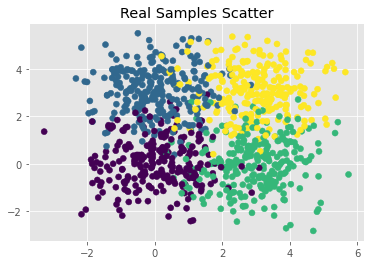

In [24]:
plot_scatter(samples=real_samples, title='Real Samples Scatter', group=groups)

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 2</span>**. Sampling with MCMC: implement the MALA algorithm to draw samples from $p(x;\{\mu_i\})$. The function will get an initial guess $\{\hat x_i\}$ and will generate chains of length $L$. Use $\sqrt{2\varepsilon} = 0.1$ and $N \sim \mathcal{N}(0,I)$.


In [37]:
def log_gradient_p(x, sigma_2=1, 
                        mu=[np.array([0,0]), np.array([0,3]),
                             np.array([3,0]), np.array([3,3])]):
    N = len(mu)
    denominator = 0
    for i in range(N):
        denominator += np.exp((-1/(2*sigma_2)) * np.linalg.norm(x-mu[i], axis=1) ** 2 )
    denominator = np.reshape(denominator, (denominator.shape[0],1))
    
    nominator = 0
    for i in range(N):  
        s = (np.exp((-1/(2*sigma_2)) * np.linalg.norm(x-mu[i], axis=1) ** 2 ))
        d = (mu[i] - x).transpose()
        nominator +=  s * d 
    
    return (1/sigma_2) * nominator.transpose() / denominator

In [82]:
def p(x, sigma_2=1,mu=[np.array([0,0]), np.array([0,3]),
                         np.array([3,0]), np.array([3,3])]):
    N = len(mu)
    sum_exp = 0
    for n in range(N):
        log_exp = -0.5 * (np.linalg.norm(x-mu[n], axis=1) ** 2)
        sum_exp += np.exp(log_exp)
    return (1/N) * (1 /(2*np.pi)) * sum_exp

In [84]:
def q(x_tag, x, epsilon):
    norm = np.linalg.norm(x_tag - x - epsilon * log_gradient_p(x), axis=1) ** 2
    log_q = -norm/(4*epsilon)
    q = np.exp(log_q)
    return q

In [162]:
def langevin_mala_dynamics(init_guess, steps=5000, samples=1000, sigma_2=1, factored_epsilon=0.1, 
                           MALA=False, verbos=False):
    epsilon = (factored_epsilon ** 2) / 2
    x = init_guess
    mala_reg_update = 0
    mala_alpha_update = 0
    mala_no_update = 0
    for s in tqdm.tqdm(range(steps)):
        noise = np.random.randn(x.shape[0], x.shape[1])
        new_x = x + epsilon * log_gradient_p(x, sigma_2=sigma_2) + factored_epsilon * noise
        
        if MALA:
            if p(new_x).sum() > p(x).sum():
                x = new_x.copy()
                mala_reg_update += 1
            else:
                p_x = p(x=x).sum()
                #print('p_x', p_x)
                p_x_new = p(x=new_x).sum()
                #print('p_x_new', p_x_new)
                q_x_x_new = q(x_tag=x, x=new_x, epsilon=epsilon).sum()
                #print('q_x_x_new', q_x_x_new)
                q_x_new_x = q(x_tag=new_x, x=x, epsilon=epsilon).sum()
                #print('q_x_new_x', q_x_new_x)
                alpha = (p_x / p_x_new) * (q_x_x_new / q_x_new_x)
                #print(alpha)
                r = np.random.uniform()
                if r < alpha:
                    x = new_x.copy()
                    mala_alpha_update += 1
                else:
                    mala_no_update += 1
                
        else:
            x = new_x.copy()
    
    if MALA and verbos:
        print(mala_reg_update / steps)
        print(mala_alpha_update / steps)
        print(mala_no_update / steps)
    
    return x

In [160]:
init_guess = np.random.uniform(low=0, high=3, size=(1_000, 2))
x = langevin_mala_dynamics(init_guess=init_guess, steps=10_000, samples=1_000, MALA=False, sigma_2=0.1)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2096.95it/s]


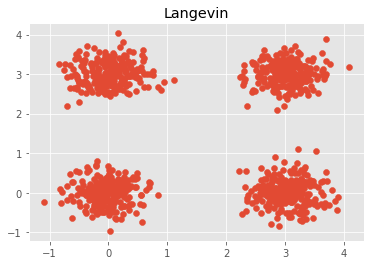

In [161]:
plot_scatter(samples=x, title='Langevin')

In [164]:
init_guess = np.random.uniform(low=0, high=3, size=(1_000, 2))
x = langevin_mala_dynamics(init_guess=init_guess, steps=10_000, samples=1_000, MALA=True, sigma_2=0.1)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 693.78it/s]


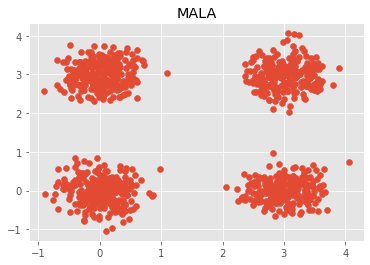

In [165]:
plot_scatter(samples=x, title='MALA')

**From now on**, we will refer to **$\{\mu_i\}$ as unknowns** and we will estimate them using different algorithms.

#### Estimation of $\{\mu_i\}$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 3</span>**. Implement Maximum likelihood (ML) estimation of $\{\mu_i\}$ using direct sampling:
* Step 1: Randomly initialize $\{\tilde \mu_i\}$ from $U([0,3]^2)$.
* Step 2: Use your function from Task 1 to draw 100 samples ${\tilde x}$ from $p(x;\{\mu_i\})$ using $\{\tilde \mu_i\}$.
* Step 3: Update $\{\tilde \mu_i\}$ using the ML gradient descent step:
$$ \tilde \mu_i ^ {k+1} = \tilde \mu_i ^ {k} + \eta\left(\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{x}-\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{\tilde x}\right),$$
where $\langle\cdot\rangle_x$ denotes averaging over the real samples from Task 1 and $\langle\cdot\rangle_{\tilde x}$ denotes averaging over the synthetically generated samples from Step 2. Use $\eta = 1$.
* Repeat Step 2 and Step 3 until convergence.

###### TODO:
1) Parallel implementation $$ $$
2) check if convergance is correct

In [256]:
def grad_mu_log_p(x, mu):
    N = len(mu)
    denominator = 0
    for n in range(N):
        log_exp = -0.5 * (np.linalg.norm(x-mu[n]) ** 2)
        denominator += np.exp(log_exp)
    
    nominator = np.zeros([N,2])
    
    for n in range(N):
        log_exp = -0.5 * (np.linalg.norm(x-mu[n]) ** 2)
        exp = np.exp(log_exp)
        nominator[n] = exp * (x-mu[n])
        
    return (1/denominator) * nominator

In [267]:
def avg_grad_mu_log_p(x, mu):
    grad = np.zeros(shape=mu.shape)
    for x_i in x:
        grad += grad_mu_log_p(x=x_i, mu=mu)
    return grad / x.shape[0]

In [309]:
def ML_DS(N, real_samples, etta=1):
    mu_hat = np.random.uniform(size=[N,2])
    step_idx = 0
    while True:
        x_hat, _ = mix_gauss_draw(N=N, sigma=1, mu=mu_hat, J=100)
        avg_mu_grad_estim = avg_grad_mu_log_p(x_hat, mu_hat)
        avg_mu_grad_real = avg_grad_mu_log_p(real_samples, mu_hat)
        
        old_mu = mu_hat.copy()
        mu_hat = mu_hat + etta * (avg_mu_grad_real - avg_mu_grad_estim)
        
        step_norm = np.linalg.norm(mu_hat - old_mu)
        
        if step_norm < 1e-1:
            print(step_norm)
            break
            
        if step_idx % 10 == 0:
            print(step_norm)
        step_idx += 1    
        
    return mu_hat

In [312]:
estim_mu = ML_DS(N=4, real_samples=real_samples, etta=1)
print("Estimated MU:\n", estim_mu)

0.9132721120506757
0.3121295680013613
0.15222985354213614
0.08905723380496144
Estimated MU:
 [[ 0.04130437  3.12242357]
 [ 0.12349884  0.15385837]
 [ 3.10996724  2.8060564 ]
 [ 2.70850445 -0.15316252]]


<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 4</span>**. Implement Maximum likelihood (ML) estimation of $\{\mu_i\}$ using MCMC:
* Step 1: Randomly initialize $\{\tilde \mu_i\}$ from $U([0,3]^2)$.
* Step 2: Use your function from Task 2 to draw 100 samples ${\tilde x}$ from $p(x;\{\mu_i\})$ using $\{\tilde \mu_i\}$. Initialize the chains with $\hat x_i \sim \mathcal{N}(1.5,2)$ and use chains length of $L=1000$.
* Step 3: Update $\{\tilde \mu_i\}$ using the ML gradient descent step:
$$ \tilde \mu_i ^ {k+1} = \tilde \mu_i ^ {k} + \eta\left(\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{x}-\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{\tilde x}\right),$$
where $\langle\cdot\rangle_x$ denotes averaging over the real samples from Task 1 and $\langle\cdot\rangle_{\tilde x}$ denotes averaging over the synthetically generated samples from Step 2. Use $\eta = 1$.
* Repeat Step 2 and Step 3 until convergence.

###### TODO:
1)what is L?

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 5</span>**. Implement Contrastive Divergence (CD) estimation of $\{\mu_i\}$ using MCMC sampling:
* Step 1: Randomly initialize $\{\tilde \mu_i\}$ from $U([0,3]^2)$.
* Step 2: Use your function from Task 2 to draw 100 samples ${\tilde x}$ from $p(x;\{\mu_i\})$ using $\{\tilde \mu_i\}$. Initialize the chains with **100 samples randomly chosen from the real set of examples from Task 1**, and use only $L=10$ update steps.
* Step 3: Update $\{\tilde \mu_i\}$ using the CD gradient descent step:
$$ \tilde \mu_i ^ {k+1} = \tilde \mu_i ^ {k} + \eta\left(\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{x}-\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{\tilde x}\right),$$
where $\langle\cdot\rangle_x$ denotes averaging over the $100$ real samples used for initialization of the chains in Step 2 and $\langle\cdot\rangle_{\tilde x}$ denotes averaging over the MCMC generated samples from Step 3. Use $\eta = 1$.
* Repeat Step 2 and Step 3 until convergence.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 6</span>**.
Present the estimated $\{\mu_i\}$ and the final random samples $\{\tilde x_i\}$ generated with each of the three algorithms in Tasks 3-5. Discuss the differences in convergence.

## Part II: Noise Contrastive Estimation (50 points)

Consider the distribution
$$p_m(x;\{\mu_i\}) = \frac{1}{Z} \sum_{i=1}^{N} \exp\left\{-\frac{1}{2\sigma^2}||x-\mu_i||^2\right\} ,$$	
where $Z \in \mathbb{R}$ is a normalization constant, and $ x,\mu_i \in \mathbb{R}^2$.

#### Sampling from GMM

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 7</span>**. What is the value of $Z$?


Easy to see that: $ \Sigma = I\sigma^2$
$$ \Rightarrow Z = \frac{1}{N}\cdot\det(2\pi\Sigma)^{-1/2}=\frac{1}{2\pi N\sigma^2} $$ 

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 8</span>**. Use $N = 4$, $\sigma = 1$, and $\{\mu_i\} = \{(0,0)^T , (0,3)^T , (3,0)^T , (3,3)^T\} $. Draw $J=1000$ samples $\{x_j\}$ from the distribution $p_m(x;\{\mu_i\})$ using the function from Task 1.

In [313]:
real_samples = mix_gauss_draw(N=4, sigma=1, mu=[np.array([0,0]),
                                     np.array([0,3]),
                                     np.array([3,0]),
                                     np.array([3,3])], J=1_000)

**From now on**, we will refer to **$\{\mu_i\}$ as unknowns** and we will estimate them using the Noise Contrastive Estimation method.

#### Estimation of $\{\mu_i\}$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 9</span>**. Implement Noise Contrastive Estimation of $\{\mu_i\}$:
* Step 1: Generating the artificial data-set of noise: Draw $J=1000$ samples $\{y_j\}$ from $$p_n(y;\mu_n) = \frac{1}{{{2\pi \sigma_n^2}}} \exp\left\{-\frac{1}{2\sigma_n^2}||y-\mu_n||^2\right\}$$
  using $\mu_n = (1,1)^T$ and $\sigma_n=2$.
* Step 2: Randomly select an initial guess for the model means $\{\tilde \mu_i\}$ from $U([0,3]^2)$.
* Step 3: Update $\{\tilde \mu_i\}$ by **maximizing**:
$$\{\tilde \mu_i\} = \underset{\{\mu_i\}}{\arg\max} \, \sum_{j=1}^{J} \left[\ln (h(x_j;\{\mu_i\})) + \ln(1-h(y_j;\{\mu_i\})) \right],$$
where
$$h(u;\{\mu_i\}) = \frac{p_m(u;\{\mu_i\})}{p_m(u;\{\mu_i\})+p_n(u;\mu_n)}.$$
  Implementation Tip: This step can be executed using the function `scipy.optimize.minimize` which finds the **minimum** of an (unconstrained) optimization problem (e.g. using the `'BFGS'` method), given a function that calculates the objective and an initial guess (see scipy documentation for more details). In our case, for **maximization**, implement a function that calculates the **minus** of the objective above.

In [381]:
def p_n(y, mu_n, sigma_n):
    norm = np.linalg.norm(y-mu_n) ** 2
    log = -norm/(2*(sigma_n**2))
    exp = np.exp(log)
    p = exp/(2*np.pi*sigma_n**2)
    return p

In [382]:
def h(x, mu):
    pm = p(x=x, sigma_2=1,mu=mu)
    pn = p_n(y=x, mu_n=np.array([1,1]), sigma_n=2)
    h_ = pm/(pm+pn)
    return h_

In [416]:
def fun(params, args):
    """
    params = \mu_i
    args = x_j
    """
    obj_sum = 0
    for x_j in args:
        x_j = x_j.reshape(1,2)
        obj_sum += np.log(h(x=x_j, mu=params)) + np.log(1-h(x=x_j, mu=params))
    
    return -obj_sum

In [417]:
noise_samples,_ = mix_gauss_draw(N=1, sigma=2, mu=[np.array([1,1])], J=1_000)
mu_hat = np.random.uniform(size=[4,2])
fun(params=mu_hat, args=noise_samples)

array([2923.15488221])

In [418]:
minimize(method='BFGS', fun=fun, x0=mu_hat, args=noise_samples)

      fun: 2092.5458248529017
 hess_inv: array([[ 2.71063526e-02, -3.80610869e-03, -5.90332308e-04,
        -1.99469446e-03, -1.45519152e-10,  3.47403041e-03,
         4.11327757e-03,  5.81148966e-03],
       [-3.80610869e-03,  6.08311406e-04,  2.63125373e-05,
         2.85740317e-04,  1.45519152e-11, -6.35339100e-04,
        -4.80490280e-04, -8.49842283e-04],
       [-5.90332308e-04,  2.63125373e-05,  1.94861211e-04,
         7.36515702e-05,  0.00000000e+00,  9.27589274e-05,
        -3.32105862e-04, -1.90673922e-04],
       [-1.99469446e-03,  2.85740317e-04,  7.36515702e-05,
         4.87302209e-04, -5.82076609e-11, -4.26846266e-04,
        -2.81352881e-04, -8.53612513e-04],
       [-1.45519152e-10,  1.45519152e-11,  0.00000000e+00,
        -5.82076609e-11,  3.63797881e-11,  0.00000000e+00,
        -3.63797881e-11,  4.36557457e-11],
       [ 3.47403041e-03, -6.35339100e-04,  9.27589274e-05,
        -4.26846266e-04,  0.00000000e+00,  9.33695319e-04,
         2.07952381e-04,  9.41202069

We will now regard both $\{\mu_i\}$ **and the normalization constant $Z$** as unknowns, and will estimate them using Noise Contrastive Estimation.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 10</span>**. Implement Noise Contrastive Estimation with an **un-normalized** probability model:
* Step 1: Generating the artificial data-set of noise: Draw $J=1000$ samples $\{y_j\}$ from $$p_n(y;\mu_n) = \frac{1}{{{2\pi \sigma_n^2}}} \exp\left\{-\frac{1}{2\sigma_n^2}||y-\mu_n||^2\right\}$$
  using $\mu_n = (1,1)^T$ and $\sigma_n=2$.
* Step 2: Randomly select an initial guess for the model means $\{\tilde \mu_i\}$ from $U([0,3]^2)$, and for the normalization constant $Z$ from $U([0.1,1])$
* Step 3: Update $\{\tilde \mu_i\}$ and $Z$ by **maximizing**:
$$\{\tilde \mu_i\}, Z = \underset{\{\mu_i\}, Z}{\arg\max} \, \sum_{j=1}^{J} \left[\ln (h(x_j;\{\mu_i\}, Z)) + \ln(1-h(y_j;\{\mu_i\}, Z)) \right],$$
where
$$h(u;\{\mu_i\}, Z) = \frac{p_m(u;\{\mu_i\}, Z)}{p_m(u;\{\mu_i\}, Z)+p_n(u;\mu_n)}.$$

#### Evaluating the Results

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 11</span>**. Visually: plot the estimates of $\{\mu_i\}$ of Tasks 9 and 10 (two separate figures). Include the model samples, the noise samples, the initial guess for the model means, and the final estimates of $\{\tilde \mu_i\}$.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 12</span>**. Quantitatively: repeat Tasks 9 and 10, this time with $J = 100\times[1,5,10,20,30,50]$. For each value of $J$ repeat the estimation process for 50 times, each time with different realizations for $\{x_j\}$ and $\{y_j\}$ and initial guesses for the estimands ($\{\mu_i\}$ in Task 9 and $\{\mu_i\},Z$ in Task 10. 

For each value of $J$, calculate the MSE between the true parameter values and their estimates (the mean will be taken over the different realizations). Note that for the model means, the MSE should be calculated to the closest true $\mu_i$ for each estimation. If at the same run two estimated $\mu_i$s pick the same true $\mu_i$, then this run should be declared as a failure and should be disregarded. Report the number of failure runs.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 13</span>**. Discussion: How does the number of samples $J$ affect the accuracy of the estimation? How does the addition of $Z$ as an unknown affect the accuracy? 